Sophia Ladyzhets, sal2213

Partner: Sally Green

## Temperature Modeling

### Objective:

Estimate difference in peak daily temperature between various weather stations in NYC and temperature readings in Central Park over a 6-8 month period. 

In [616]:
import requests
import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt, dates as mdates
import datetime as datetime


In [617]:
#initialize necessary constants

#convective heat transfer
L = 80 
rho = 1.22
mu = 17.93*10**-6
k = .02557  ##assuming constant

Re_x = lambda u: rho * u * L / mu
Pr = .71

#solar radiation
alpha_qs = 200.0
sigma = 5.67*10**-8
epsilon = .85
T_sky = 280
T_g_ref = 300 ##place holder

# evaporative heat transfer
# evap_dict = {'March':1.19E-08, 'April':2.50E-08, 'May':2.65E-08, 'June':1.98E-08, 'July':1.53E-08, 'August':1.18E-08, 'September':2.99E-08}
#define evaporation constant d based on monthly precipitation data
# evap_dict = {3 : 1.19E-08, 4 : 2.50E-08, 5 : 2.65E-08, 6 : 1.98E-08, 7 : 1.53E-08, 8 : 1.18E-08, 9 : 2.99E-08}
evap_list = [1.19E-08, 2.50E-08, 2.65E-08, 1.98E-08, 1.53E-08, 1.18E-08, 2.99E-08]

# q = 2256 kJ/kg * 1000 kg/m^3 * 1 m * 1 m * d
q_evap = lambda d: (2256.0*10**6)*d

In [618]:
%run WeatherData_Fxns_SAL.py

## Load data 

Sources: WU Stations and Central Park 

In [619]:

wu_list = ['1421', '1622', '1238', '1626',
           '1571', '1387', '982', '1615']
#note: removed stations 5 and 6 (and 9 temporarily)

first_day = '2022-03-01'
last_day = '2022-10-31'


In [620]:
data_0 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[0]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
                                                                                                                                                            # 'Wind Gust': str, 'Pressure': str,
                                                                                                                                                            # 'Precip.': str})
data_1 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[1]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_2 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[2]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_3 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[3]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_4 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[4]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
##temp load data_5 and data_6 as july only data since I don't have 8 mnths yet
# data_5 = data_1300
# data_6 = data_1651

data_5 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[5]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_6 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[6]+'_wunderground_'+first_day+'_'+'2022-08-16.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_7 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[7]+'_wunderground_'+first_day+'_'+'2022-03-10.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})

data_0.dtypes


c:\Users\sophi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Time               object
Temperature        object
Dew Point          object
Humidity           object
Wind               object
Speed              object
Gust               object
Pressure           object
Precip. Rate.      object
Precip. Accum.     object
UV                float64
Solar              object
Date               object
dtype: object

In [621]:
data_0.head()

,Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,UV,Solar,Date
0,NaN,NaN,,,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-01
1,12:04 AM,32.2 °F,--,32 °%,North,2.8 °mph,5.6 °mph,29.99 °in,--,--,NaN,w/m²,2022-03-01
2,12:09 AM,32.0 °F,--,31 °%,North,3.3 °mph,7.5 °mph,29.99 °in,--,--,NaN,w/m²,2022-03-01
3,12:14 AM,32.0 °F,--,30 °%,North,2.6 °mph,7.5 °mph,29.99 °in,--,--,NaN,w/m²,2022-03-01
4,12:19 AM,32.1 °F,--,30 °%,North,2.3 °mph,7.5 °mph,29.99 °in,--,--,NaN,w/m²,2022-03-01


In [622]:
weather_data_list = [data_0, data_1, data_2, data_3,
                     data_4, data_5, data_6, data_7]


for i in range(len(weather_data_list)):
    weather_data_list[i] = weather_data_list[i].replace(to_replace='--', value=np.nan)
    weather_data_list[i] = weather_data_list[i].replace(to_replace='  ', value=np.nan)
    weather_data_list[i] = weather_data_list[i].replace(to_replace='', value=np.nan)
    weather_data_list[i] = weather_data_list[i].dropna(thresh=3)
    weather_data_list[i]['Temperature'] = weather_data_list[i]['Temperature'].str.strip(' \xa0°F')
    weather_data_list[i]['Temperature'] = weather_data_list[i]['Temperature'].astype(float)
    weather_data_list[i]['Speed'] = weather_data_list[i]['Speed'].astype(str)
    weather_data_list[i]['Speed'] = weather_data_list[i]['Speed'].str.strip(" °mph,' ")
    weather_data_list[i]['Speed'] = weather_data_list[i]['Speed'].astype(float)
    weather_data_list[i]['Humidity'] = weather_data_list[i]['Humidity'].astype(str)
    weather_data_list[i]['Humidity'] = weather_data_list[i]['Humidity'].str.strip(" °%',")
    weather_data_list[i]['Humidity'] = weather_data_list[i]['Humidity'].astype(float)
  


In [623]:
central_park = pd.read_csv('Central Park Weather Data March to Sept 2022.csv')

central_park = central_park.replace(to_replace='--', value=np.nan)
central_park = central_park.dropna(thresh=3)
central_park = central_park.drop(
    ['STATION', 'NAME', 'PGTM', 'PGTM_ATTRIBUTES', 'TAVG',
     'TAVG_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES',  'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'TMAX_ATTRIBUTES'], axis=1)
central_park.head()


,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,...,TMAX,TMIN,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES
0,40.77898,-73.96925,42.7,2022-03-01,2.6,",,W",0.0,",,W,2400",0.0,",,W,2400",...,8.9,-0.5,180,",,W",200,",,W",6.3,",,W",10.7,",,W"
1,40.77898,-73.96925,42.7,2022-03-02,2.4,",,W",0.0,",,W,2400",0.0,",,W,2400",...,11.1,4.4,240,",,W",250,",,W",5.8,",,W",9.4,",,W"
2,40.77898,-73.96925,42.7,2022-03-03,4.3,",,W",0.8,",,W,2400",0.0,",,W,2400",...,8.9,-4.3,300,",,W",320,",,W",8.1,",,W",13.4,",,W"
3,40.77898,-73.96925,42.7,2022-03-04,2.4,",,W",0.0,",,W,2400",0.0,",,W,2400",...,2.8,-6.0,240,",,W",230,",,W",5.8,",,W",9.4,",,W"
4,40.77898,-73.96925,42.7,2022-03-05,1.6,",,W",0.0,",,W,2400",0.0,",,W,2400",...,7.8,0.0,160,",,W",130,",,W",5.8,",,W",9.4,",,W"


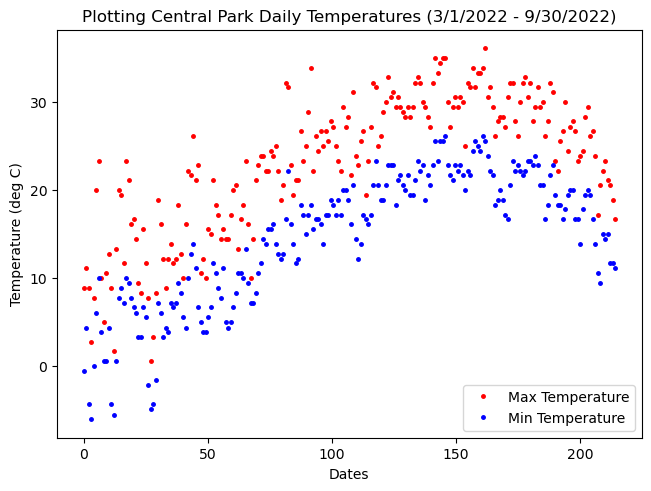

In [624]:

T_min_ctrl = central_park['TMIN']
x_min_ctrl = np.linspace(0.0, T_min_ctrl.shape[0], T_min_ctrl.shape[0])
T_max_ctrl = central_park['TMAX']
x_max_ctrl = np.linspace(0.0, T_max_ctrl.shape[0], T_max_ctrl.shape[0])

#plotting central park weather data
fig = plt.figure(constrained_layout = True)
ax = plt.gca()
ax.plot(x_max_ctrl, T_max_ctrl, 'ro', markersize=2.5, label='Max Temperature')  ##close to Central Park (uptown - Harlem)
ax.plot(x_min_ctrl, T_min_ctrl, 'bo', markersize=2.5, label='Min Temperature')  ##close to Central Park (uptown - Harlem)
ax.set_xlabel("Dates")
ax.set_ylabel("Temperature (deg C)")
ax.set_title('Plotting Central Park Daily Temperatures (3/1/2022 - 9/30/2022)')
plt.legend(loc='lower right')
plt.show()


### Preliminary Analysis
Calculate min and max daily temperatures for WU stations

In [625]:
#calculating min and max temp per day from WU data
#reference: https://github.com/arvindnswamy/IntroToPythonForMEstudents/blob/main/IntroductionToPython_PandasNumpyScipyMatplotlib.ipynb

wd_avgdailytemp_list = []
wd_mindailytemp_list = []
wd_maxdailytemp_list = []

for i in range(len(weather_data_list)):
    wd_dailytemp_avg = weather_data_list[i].groupby(by=['Date']).mean(['Temperature'])
    wd_dailytemp_min = weather_data_list[i].groupby(by=['Date']).min(['Temperature'])
    wd_dailytemp_max = weather_data_list[i].groupby(by=['Date']).max(['Temperature'])
    # print(wd_dailytemp_max['Temperature'])
    wd_dailytemp_avg['Temperature'][:] = (wd_dailytemp_avg['Temperature'][:] - 32.0 )*(5.0/9.0) 
    wd_dailytemp_min['Temperature'][:] = (wd_dailytemp_min['Temperature'][:] - 32.0 )*(5.0/9.0) 
    wd_dailytemp_max['Temperature'][:] = (wd_dailytemp_max['Temperature'][:] - 32.0)*(5.0/9.0)
    wd_dailytemp_max = wd_dailytemp_max.assign(DATE=wd_dailytemp_max.axes[0])
    # wd_dailytemp_max = wd_dailytemp_max.assign(MONTH=wd_dailytemp_max['DATE'].dt.month)
    wd_avgdailytemp_list.append(wd_dailytemp_avg)
    wd_mindailytemp_list.append(wd_dailytemp_min)
    wd_maxdailytemp_list.append(wd_dailytemp_max)

print(wd_maxdailytemp_list[0].info())
# print(wd_maxdailytemp_list[0]['Speed'])


<class 'pandas.core.frame.DataFrame'>
Index: 237 entries, 2022-03-01 to 2022-10-31
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     237 non-null    float64
 1   Dew Point       0 non-null      float64
 2   Humidity        237 non-null    float64
 3   Speed           237 non-null    float64
 4   Precip. Rate.   0 non-null      float64
 5   Precip. Accum.  0 non-null      float64
 6   UV              0 non-null      float64
 7   DATE            237 non-null    object 
dtypes: float64(7), object(1)
memory usage: 16.7+ KB
None


### Comparing Trends

Temperature difference between WU stations and Central Park

In [626]:
#calculating min and max temp per day from WU data
#reference: https://github.com/arvindnswamy/IntroToPythonForMEstudents/blob/main/IntroductionToPython_PandasNumpyScipyMatplotlib.ipynb

wd_maxdailytemp_list = []

for i in range(len(weather_data_list)):
    wd_dailytemp_max = weather_data_list[i].groupby(by=['Date']).max(['Temperature'])
    wd_dailytemp_max['Temperature'][:] = (wd_dailytemp_max['Temperature'][:] - 32.0 )*(5.0/9.0)  #convert F to C
    wd_dailytemp_max['Speed'][:] = wd_dailytemp_max['Speed'][:]*0.44704  ## 1 mph = 0.44704 m/s
    wd_dailytemp_max = wd_dailytemp_max.assign(DATE=wd_dailytemp_max.axes[0])
    wd_dailytemp_max = wd_dailytemp_max.rename(columns={'Temperature': 'T_max'+wu_list[i], 'Humidity':'Rel_Humidity'+wu_list[i], 'Speed':'U_inf'+wu_list[i]})

    wd_maxdailytemp_list.append(wd_dailytemp_max)

print(wd_maxdailytemp_list[3].info())
print(wd_maxdailytemp_list[6].info())
# print(wd_maxdailytemp_list[6]['U_inf'+wu_list[6]])


<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 2022-05-12 to 2022-10-31
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   T_max1626         172 non-null    float64
 1   Rel_Humidity1626  172 non-null    float64
 2   U_inf1626         172 non-null    float64
 3   UV                172 non-null    float64
 4   High              0 non-null      float64
 5   Low               0 non-null      float64
 6   Average           0 non-null      float64
 7   DATE              172 non-null    object 
dtypes: float64(7), object(1)
memory usage: 12.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 2022-03-01 to 2022-08-15
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   T_max982         156 non-null    float64
 1   Rel_Humidity982  156 non-null    float64
 2   U_inf982         156 non-null    float64
 3   UV     

In [627]:
#define new wu_list without stations 3 and 6

wu_list_n = ['1421', '1622', '1238', '1571', '1387']
wd_maxdailytemp_list_n = [wd_maxdailytemp_list[0], wd_maxdailytemp_list[1], wd_maxdailytemp_list[2], wd_maxdailytemp_list[4], wd_maxdailytemp_list[5]]

In [628]:

df_combo = pd.merge(wd_maxdailytemp_list[0], central_park, how='inner', on=['DATE'])
df_combo = df_combo.drop(['PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 
                          'WDF2', 'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'WSF2',
                          'WSF2_ATTRIBUTES', 'WSF5', 'WSF5_ATTRIBUTES', 'Dew Point'], axis=1)

df_combo = df_combo.rename(columns={'TMAX':'T_max_ctrl'})
df_combo = df_combo.assign(T_max_ctrl_Kelv=df_combo['T_max_ctrl']+273.15)

# for i in range(len(wu_list_n)):
df_combo = df_combo.assign(Tdif0=df_combo['T_max'+wu_list_n[0]]-df_combo['T_max_ctrl'])
df_combo = df_combo.rename(columns={'Tdif0':'T_dif'+wu_list[0]})
df_combo = df_combo.assign(T_Kelv=df_combo['T_max'+wu_list[0]]+273.15)  #Kelvin = 273.15 + deg C
df_combo = df_combo.rename(columns={'T_Kelv':'T_Kelv'+wu_list[0]})
df_combo = df_combo.assign(Re=Re_x(df_combo['U_inf'+wu_list[0]]))
df_combo = df_combo.rename(columns={'Re':'Re'+wu_list[0]})
df_combo = df_combo.assign(q_conv=q_conv(df_combo['T_Kelv'+wu_list[0]],df_combo['U_inf'+wu_list[0]]))
df_combo = df_combo.rename(columns={'q_conv':'q_conv'+wu_list[0]})
df_combo = df_combo.assign(T_ground=ground_temp(
    df_combo['T_Kelv'+wu_list[0]], df_combo['U_inf'+wu_list[0]]))
df_combo = df_combo.rename(columns={'T_ground': 'T_ground'+wu_list[0]})

for i in range(1, len(wd_maxdailytemp_list_n)):
    df_combo = pd.merge(df_combo, wd_maxdailytemp_list_n[i], how='inner', on=['DATE'])
    df_combo = df_combo.assign(Tdif=df_combo['T_max'+wu_list_n[i]]-df_combo['T_max_ctrl'])
    df_combo = df_combo.rename(columns={'Tdif':'T_dif'+wu_list_n[i]})
    df_combo = df_combo.assign(T_Kelv=df_combo['T_max'+wu_list_n[1]]+273.15)
    df_combo = df_combo.rename(columns={'T_Kelv':'T_Kelv'+wu_list_n[i]})
    df_combo = df_combo.assign(Re=Re_x(df_combo['U_inf'+wu_list_n[i]]))
    df_combo = df_combo.rename(columns={'Re':'Re'+wu_list_n[i]})
    df_combo = df_combo.assign(q_conv=q_conv(df_combo['T_Kelv'+wu_list_n[i]],df_combo['U_inf'+wu_list_n[i]]))
    df_combo = df_combo.rename(columns={'q_conv':'q_conv'+wu_list_n[i]})
    df_combo = df_combo.assign(T_ground=ground_temp(df_combo['T_Kelv'+wu_list_n[i]], df_combo['U_inf'+wu_list_n[i]]))
    df_combo = df_combo.rename(columns={'T_ground': 'T_ground'+wu_list_n[i]})


df_combo = df_combo.drop(['Precip. Rate.', 'Precip. Accum.'], axis=1)
df_combo.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   T_max1421         200 non-null    float64
 1   Rel_Humidity1421  200 non-null    float64
 2   U_inf1421         200 non-null    float64
 3   UV_x              0 non-null      float64
 4   DATE              200 non-null    object 
 5   LATITUDE          200 non-null    float64
 6   LONGITUDE         200 non-null    float64
 7   ELEVATION         200 non-null    float64
 8   AWND              200 non-null    float64
 9   AWND_ATTRIBUTES   200 non-null    object 
 10  PRCP              200 non-null    float64
 11  T_max_ctrl        200 non-null    float64
 12  TMIN              200 non-null    float64
 13  T_max_ctrl_Kelv   200 non-null    float64
 14  T_dif1421         200 non-null    float64
 15  T_Kelv1421        200 non-null    float64
 16  Re1421            200 non-null    float64
 1

c:\Users\sophi\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Passing 'suffixes' which cause duplicate columns {'UV_x'} in the result is deprecated and will raise a MergeError in a future version.


In [698]:
#format the dates as datetime object to enable correct plotting

from datetime import datetime

df_combo['DATE'] = df_combo['DATE'].replace(to_replace='', value=np.nan)
df_combo['DATE'] = df_combo['DATE'].dropna()
df_combo['DATE'] = df_combo['DATE'].astype(str)
df_combo['DATE'] = df_combo['DATE'].str.strip(" ,''")
df_combo['DATE'] = pd.to_datetime(df_combo['DATE'], utc=True)
df_combo = df_combo.assign(MONTH=df_combo['DATE'].dt.month)
df_combo = df_combo.assign(DAY_INDEX=df_combo['DATE'].dt.dayofyear)
df_combo = df_combo.assign(evap_d=df_combo['MONTH'])
df_combo = df_combo.assign(Re_ctrl=Re_x(df_combo['AWND']))
# df_combo = df_combo.rename(columns={'Re': 'Re'+wu_list_n[i]})

df_combo['evap_d'] = np.where(df_combo['evap_d']== 3, 1.19E-08, 0.0)
df_combo['evap_d'] = np.where(df_combo['MONTH']== 4, 2.50E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 5, 2.65E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 6, 1.98E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 7, 1.53E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 8, 1.18E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 9, 2.99E-08, df_combo['evap_d'])
df_combo = df_combo.assign(q_evap_ctrl=q_evap(df_combo['evap_d']))
df_combo = df_combo.assign(T_ground_ctrl=ground_temp_ctrl(df_combo['T_max_ctrl_Kelv'], df_combo['AWND'],df_combo['evap_d']))
df_combo.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 72 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   T_max1421          200 non-null    float64            
 1   Rel_Humidity1421   200 non-null    float64            
 2   U_inf1421          200 non-null    float64            
 3   UV_x               0 non-null      float64            
 4   DATE               200 non-null    datetime64[ns, UTC]
 5   LATITUDE           200 non-null    float64            
 6   LONGITUDE          200 non-null    float64            
 7   ELEVATION          200 non-null    float64            
 8   AWND               200 non-null    float64            
 9   AWND_ATTRIBUTES    200 non-null    object             
 10  PRCP               200 non-null    float64            
 11  T_max_ctrl         200 non-null    float64            
 12  TMIN               200 non-null    float64        

In [630]:
for i in range(0, len(wd_maxdailytemp_list_n)):
    df_combo = df_combo.assign(Tdif_ground=df_combo['T_ground'+wu_list_n[i]]-df_combo['T_ground_ctrl'])
    df_combo = df_combo.rename(columns={'Tdif_ground':'T_dif_ground'+wu_list_n[i]})

    df_combo = df_combo.assign(T_ground_var=ground_temp_solar_var(df_combo['T_Kelv'+wu_list_n[i]], df_combo['U_inf'+wu_list_n[i]], df_combo['DAY_INDEX']))
    df_combo = df_combo.rename(columns={'T_ground_var': 'T_ground_var'+wu_list_n[i]})
    df_combo = df_combo.assign(T_ground_ctrl_var=ground_temp_ctrl_var(df_combo['T_max_ctrl_Kelv'], df_combo['AWND'], df_combo['evap_d'], df_combo['DAY_INDEX']))

# df_combo.info()

In [694]:
# df_combo['DATE']
date_July = datetime.strptime("2022-07-22", "%Y-%m-%d")
date_August = datetime.strptime("2022-08-14", "%Y-%m-%d")
date_September = datetime.strptime("2022-09-08", "%Y-%m-%d")
July_1 = datetime.strptime('2022-07-01', "%Y-%m-%d")
Sept_30 = datetime.strptime('2022-09-30', "%Y-%m-%d")

# '2022-07-22'.to_datetime(utc=True)

<Figure size 640x480 with 0 Axes>

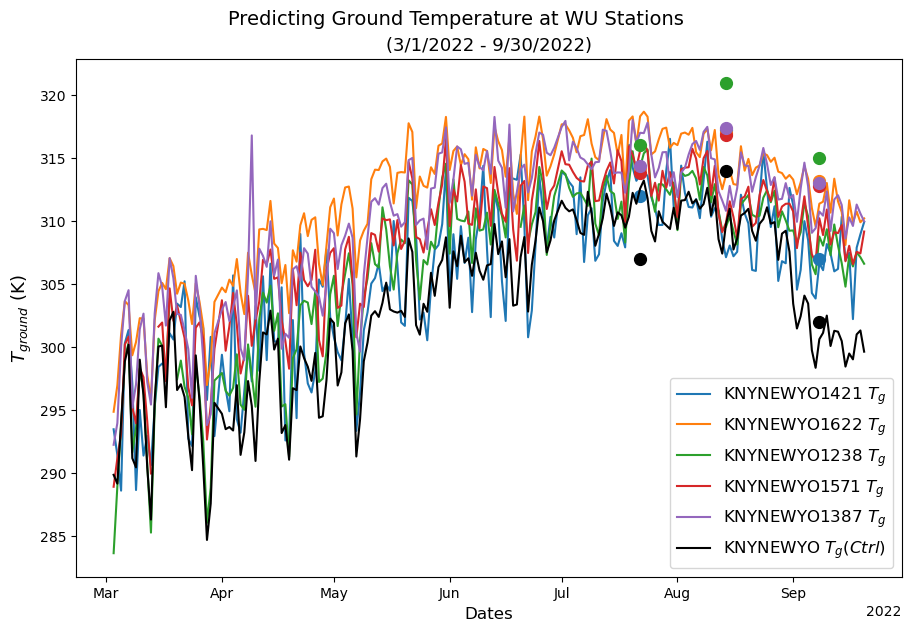

In [690]:
#plotting central park weather data
fig = plt.figure(constrained_layout=True)
fig = plt.figure(constrained_layout=True, figsize=(9,6.2))

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[0]], markersize=2.5, label=r'KNYNEWYO'+wu_list[0]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[1]], markersize=2.5, label=r'KNYNEWYO'+wu_list[1]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[2]], markersize=2.5, label=r'KNYNEWYO'+wu_list[2]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[4]], markersize=2.5, label=r'KNYNEWYO'+wu_list[4]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[5]], markersize=2.5, label=r'KNYNEWYO'+wu_list[5]+' $T_g$')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 312.0, 'o', color='tab:blue', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[0]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 314.0, 'o', color='tab:orange', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[1]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 316.0, 'o', color='tab:green', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[2]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 314.0, 'o', color='tab:red', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[3]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 314.0, 'o', color='tab:purple', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[4]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# close to Central Park (uptown - Harlem))
ax.plot(date_July, 312.0, 'o', color='tab:blue', markersize=8.5)  # close to Central Park (uptown - Harlem))
ax.plot(date_July, 314.2, 'o', color='tab:orange', markersize=8.5)
ax.plot(date_July, 316.0, 'o', color='tab:green', markersize=8.5) # close to Central Park (uptown - Harlem))
ax.plot(date_July, 313.8, 'o', color='tab:red', markersize=8.5) 
ax.plot(date_July, 314.4, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_July, 307.0, 'ok', markersize=8.5)
# close to Central Park (uptown - Harlem))
ax.plot(date_August, 317.2, 'o', color='tab:blue', markersize=8.5)
ax.plot(date_August, 317.0, 'o', color='tab:orange', markersize=8.5)
# close to Central Park (uptown - Harlem))
ax.plot(date_August, 321.0, 'o', color='tab:green', markersize=8.5)
ax.plot(date_August, 316.8, 'o', color='tab:red', markersize=8.5)
ax.plot(date_August, 317.4, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_August, 314.0, 'ok', markersize=8.5)
ax.plot(date_September, 307.0, 'o', color='tab:blue', markersize=8.5)  # close to Central Park (uptown - Harlem))
ax.plot(date_September, 313.2, 'o', color='tab:orange', markersize=8.5)
ax.plot(date_September, 315.0, 'o', color='tab:green', markersize=8.5) # close to Central Park (uptown - Harlem))
ax.plot(date_September, 312.8, 'o', color='tab:red', markersize=8.5) 
ax.plot(date_September, 313.0, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_September, 302.0, 'ok', markersize=8.5)
ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl_var'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  # close to Central Park (uptown - Harlem))
    
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel(r"$T_{ground}$ (K)", fontsize=13)
plt.suptitle('Predicting Ground Temperature at WU Stations', fontsize=14)
ax.set_title('(3/1/2022 - 9/30/2022)', fontsize=13)
plt.legend(loc='lower right', fontsize=12)
plt.show()


<Figure size 640x480 with 0 Axes>

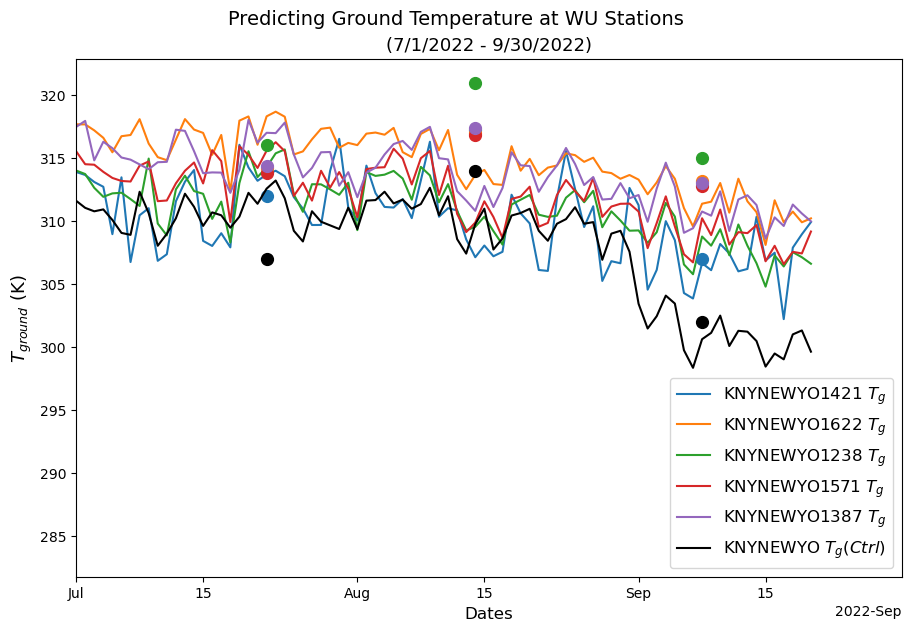

In [696]:
#plotting central park weather data
fig = plt.figure(constrained_layout=True)
fig = plt.figure(constrained_layout=True, figsize=(9,6.2))

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[0]], markersize=2.5, label=r'KNYNEWYO'+wu_list[0]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[1]], markersize=2.5, label=r'KNYNEWYO'+wu_list[1]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[2]], markersize=2.5, label=r'KNYNEWYO'+wu_list[2]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[4]], markersize=2.5, label=r'KNYNEWYO'+wu_list[4]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[5]], markersize=2.5, label=r'KNYNEWYO'+wu_list[5]+' $T_g$')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 312.0, 'o', color='tab:blue', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[0]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 314.0, 'o', color='tab:orange', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[1]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 316.0, 'o', color='tab:green', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[2]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 314.0, 'o', color='tab:red', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[3]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# ax.plot(date_July, 314.0, 'o', color='tab:purple', markersize=8.5, label=r'KNYNEWYO'+wu_list_n[4]+' $T_g$ (meas. 2002)')  # close to Central Park (uptown - Harlem))
# close to Central Park (uptown - Harlem))
ax.plot(date_July, 312.0, 'o', color='tab:blue', markersize=8.5)  # close to Central Park (uptown - Harlem))
ax.plot(date_July, 314.2, 'o', color='tab:orange', markersize=8.5)
ax.plot(date_July, 316.0, 'o', color='tab:green', markersize=8.5) # close to Central Park (uptown - Harlem))
ax.plot(date_July, 313.8, 'o', color='tab:red', markersize=8.5) 
ax.plot(date_July, 314.4, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_July, 307.0, 'ok', markersize=8.5)
# close to Central Park (uptown - Harlem))
ax.plot(date_August, 317.2, 'o', color='tab:blue', markersize=8.5)
ax.plot(date_August, 317.0, 'o', color='tab:orange', markersize=8.5)
# close to Central Park (uptown - Harlem))
ax.plot(date_August, 321.0, 'o', color='tab:green', markersize=8.5)
ax.plot(date_August, 316.8, 'o', color='tab:red', markersize=8.5)
ax.plot(date_August, 317.4, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_August, 314.0, 'ok', markersize=8.5)
ax.plot(date_September, 307.0, 'o', color='tab:blue', markersize=8.5)  # close to Central Park (uptown - Harlem))
ax.plot(date_September, 313.2, 'o', color='tab:orange', markersize=8.5)
ax.plot(date_September, 315.0, 'o', color='tab:green', markersize=8.5) # close to Central Park (uptown - Harlem))
ax.plot(date_September, 312.8, 'o', color='tab:red', markersize=8.5) 
ax.plot(date_September, 313.0, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_September, 302.0, 'ok', markersize=8.5)
ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl_var'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  # close to Central Park (uptown - Harlem))
    
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel(r"$T_{ground}$ (K)", fontsize=13)
plt.suptitle('Predicting Ground Temperature at WU Stations', fontsize=14)
ax.set_title('(7/1/2022 - 9/30/2022)', fontsize=13)
ax.set_xlim(July_1, Sept_30)
plt.legend(loc='lower right', fontsize=12)
plt.show()


In [760]:
#printing values for temp data on dates of interest (for historical comparison)
from datetime import timezone

# predicted_temp_arr = np.empty((3,len(wu_list_n)+1)):
dates_list = [date_July, date_August, date_September]
dates_list_str = [str(date_July), str(date_August), str(date_September)]
# print(dates_list_str[0])
# date_July_utc = datetime.from
# >> >  # alternative to '.utcfromtimestamp()'
# >> > dt_ts = datetime.fromtimestamp(1571595618.0, tz=timezone.utc)
# df_combo.loc[df_combo['DATE'] == date_July]
df_combo = df_combo.assign(DATE_datetime=df_combo['DATE'])
df_combo['DATE_datetime'] = df_combo['DATE_datetime'].astype(str)
df_combo['DATE_datetime'] = df_combo['DATE_datetime'].str.slice(0,19,1)
# print(df_combo['DATE_datetime'])

df_combo.loc[df_combo['DATE_datetime'].isin(dates_list_str)]

for i in range(len(wu_list_n)):
    print(df_combo.loc[df_combo['DATE_datetime'].isin(dates_list_str), 'T_ground_var'+wu_list_n[i]])
print(df_combo.loc[df_combo['DATE_datetime'].isin(dates_list_str), 'T_ground_ctrl_var'])
#     print(df_combo.loc[0,'T_ground_var'+wu_list_n[i]])

# df_combo
# np.where(df_combo['DATE']== date_July, 2.50E-08, df_combo['evap_d'])


139    313.695842
162    307.128333
187    306.654213
Name: T_ground_var1421, dtype: float64
139    318.315054
162    313.662358
187    311.377008
Name: T_ground_var1622, dtype: float64
139    314.279327
162    309.543144
187    308.772112
Name: T_ground_var1238, dtype: float64
139    315.591319
162    309.877898
187    310.221616
Name: T_ground_var1571, dtype: float64
139    317.009578
162    310.811038
187    310.756059
Name: T_ground_var1387, dtype: float64
139    312.575134
162    309.754680
187    300.618526
Name: T_ground_ctrl_var, dtype: float64


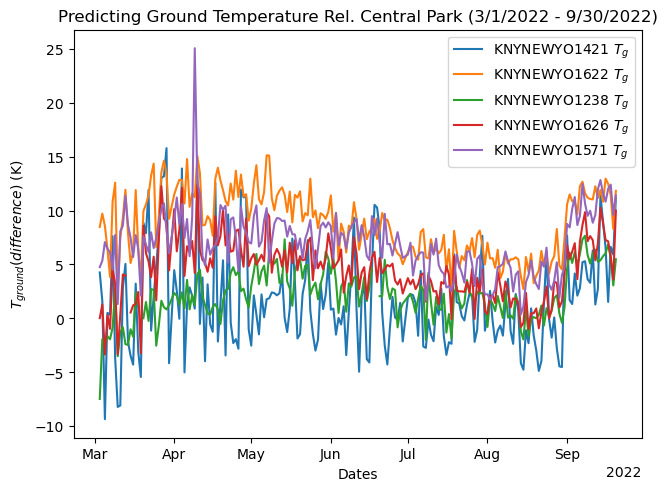

In [632]:
#plotting central park weather data
fig = plt.figure(constrained_layout=True)
# fig = plt.figure(constrained_layout=True, figsize=(20,10))

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['T_dif_ground'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_g$')  

ax.set_xlabel("Dates")
ax.set_ylabel(r"$T_{ground}(difference)$ (K)")
ax.set_title('Predicting Ground Temperature Rel. Central Park (3/1/2022 - 9/30/2022)')
plt.legend(loc='upper right')
plt.show()


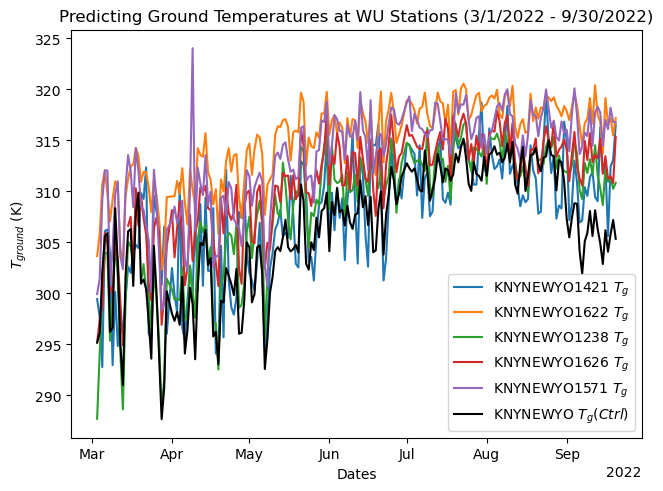

In [633]:
# df_combo.plot.scatter(x='DATE', y='T_dif'+wu_list[0])

#plotting central park weather data
fig = plt.figure(constrained_layout=True)
# fig = plt.figure(constrained_layout=True, figsize=(20,10))
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['T_ground'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_g$')  
ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  

ax.set_xlabel("Dates")
ax.set_ylabel(r"$T_{ground}$ (K)")
ax.set_title('Predicting Ground Temperatures at WU Stations (3/1/2022 - 9/30/2022)')
plt.legend(loc='lower right')
plt.show()


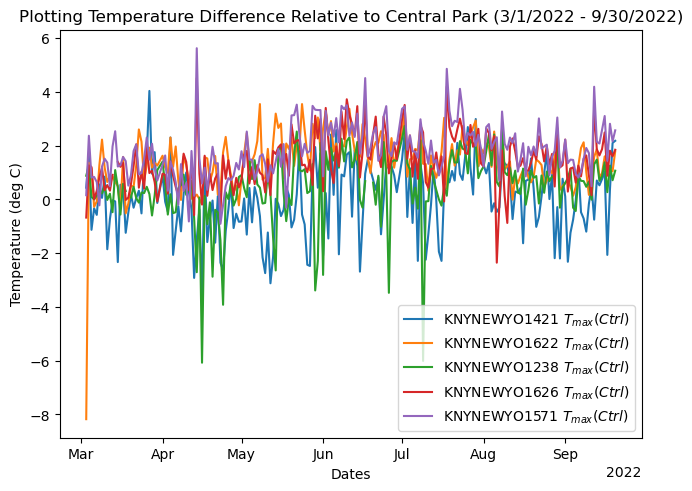

In [635]:
# df_combo.plot.scatter(x='DATE', y='T_dif'+wu_list[0])

#plotting central park weather data
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['T_dif'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{max} (Ctrl)$')  
    
ax.set_xlabel("Dates")
ax.set_ylabel("Temperature (deg C)")
ax.set_title('Plotting Temperature Difference Relative to Central Park (3/1/2022 - 9/30/2022)')
plt.legend(loc='lower right')
plt.show()


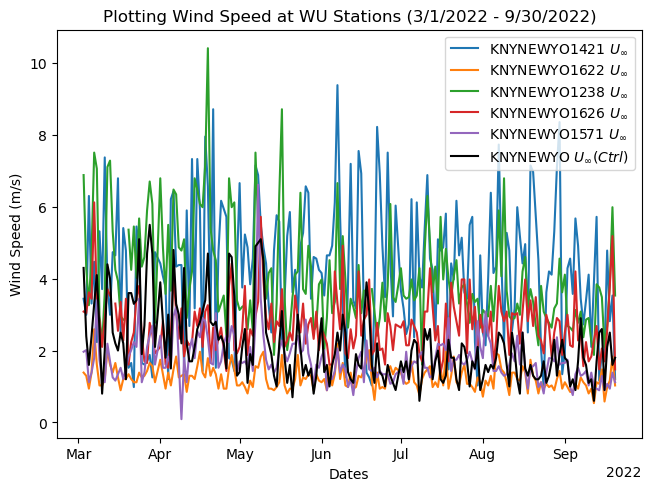

In [697]:
#plotting wind speed data
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $U_{\infty}$')  
# ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list[0]], markersize=2.5, label=r'KNYNEWYO'+wu_list[0]+' $U_{\infty}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list[1]], markersize=2.5, label=r'KNYNEWYO'+wu_list[1]+' $U_{\infty}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list[2]], markersize=2.5, label=r'KNYNEWYO'+wu_list[2]+' $U_{\infty}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list[4]], markersize=2.5, label=r'KNYNEWYO'+wu_list[4]+' $U_{\infty}$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['AWND'], '-k', markersize=2.5,
        label=r'KNYNEWYO $U_{\infty} (Ctrl)$')  
    
ax.set_xlabel("Dates")
ax.set_ylabel("Wind Speed (m/s)")
ax.set_title('Plotting Wind Speed at WU Stations (3/1/2022 - 9/30/2022)')
plt.legend(loc='upper right')
plt.show()


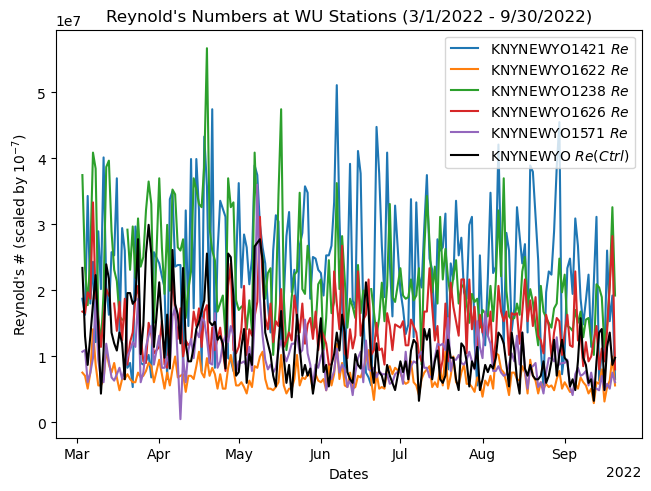

In [705]:
#plotting Reynold's #
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['Re'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $Re$')  
ax.plot(df_combo['DATE'], df_combo['Re_ctrl'], '-k', markersize=2.5,
        label=r'KNYNEWYO $Re (Ctrl)$')  
    
ax.set_xlabel("Dates")
ax.set_ylabel(r"Reynold's # (scaled by $10^{-7}$)")
ax.set_title("Reynold's Numbers at WU Stations (3/1/2022 - 9/30/2022)")
plt.legend(loc='upper right')
plt.show()


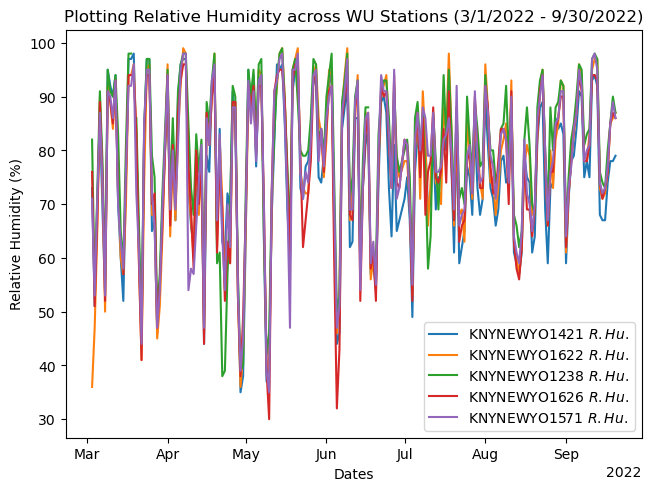

In [637]:
#plotting relative humidity data
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['Rel_Humidity'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $R. Hu.$')  
    
ax.set_xlabel("Dates")
ax.set_ylabel("Relative Humidity (%)")
ax.set_title('Plotting Relative Humidity across WU Stations (3/1/2022 - 9/30/2022)')
plt.legend(loc='lower right')
plt.show()


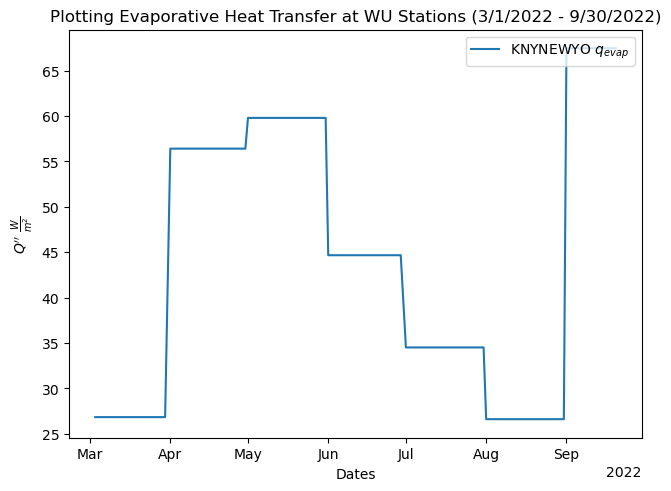

In [638]:
#plotting evaporative heat transfer by month in Central Park
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(df_combo['DATE'], df_combo['q_evap_ctrl'], markersize=2.5, label=r'KNYNEWYO $q_{evap}$')  

ax.set_xlabel("Dates")
ax.set_ylabel(r"$Q''$ $\frac{W}{m^2}$")
ax.set_title('Plotting Evaporative Heat Transfer at WU Stations (3/1/2022 - 9/30/2022)')
plt.legend(loc='upper right')
plt.show()


In [639]:
#first approximation: assume no evaporation and forced convection -> q_solar = q_conv



In [640]:
# # df_combo.plot.scatter(x='DATE', y='T_dif'+wu_list[0])

# #plotting central park weather data
# fig = plt.figure(constrained_layout=True)
# ax = plt.gca()
# locator = mdates.AutoDateLocator()
# formatter = mdates.ConciseDateFormatter(locator)
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)
# # ax.plot(df_combo['DATE'], df_combo['T_dif'+wu_list[0]], markersize=2.5, label=r'KNYNEWYO'+wu_list[0]+' $T_{max}$')  ##close to Central Park (uptown - Harlem))
# # for i in range(len(wu_list)-1):
# #     ax.plot(df_combo['DATE'], df_combo['T_dif'+wu_list[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{max}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['T_Kelv'+wu_list[0]], markersize=2.5, label=r'KNYNEWYO'+wu_list[0]+' $T_{max}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['T_Kelv'+wu_list[1]], markersize=2.5, label=r'KNYNEWYO'+wu_list[1]+' $T_{max}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['T_Kelv'+wu_list[2]], markersize=2.5, label=r'KNYNEWYO'+wu_list[2]+' $T_{max}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['T_Kelv'+wu_list[4]], markersize=2.5, label=r'KNYNEWYO'+wu_list[4]+' $T_{max}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['T_Kelv'+wu_list[5]], markersize=2.5, label=r'KNYNEWYO'+wu_list[5]+' $T_{max}$')  # close to Central Park (uptown - Harlem))
    
# ax.set_xlabel("Dates")
# ax.set_ylabel("Temperature (K)")
# ax.set_title('Plotting Temperatures at WU Stations (3/1/2022 - 9/30/2022)')
# plt.legend(loc='lower right')
# plt.show()


In [641]:
# weather_data_list[0]['Speed'].convert_dtypes(convert_floating=True)
# weather_data_list[0].info()
# weather_data_list[0]['Humidity']
# weather_data_list[0]['Wind']
# np.min(weather_data_list[0]['Speed'])
# weather_data_list[0]['Speed']


In [642]:
# df_combo['DAY_INDEX']
# ground_temp_solar_var()
# q_evap_ctrl=q_evap(df_combo['evap_d']))
# df_combo['evap_d']

In [643]:
# #convective heat transfer
# # L = 80 
# # rho = 1.22
# # mu = 17.93*10**-6
# # k = .02557  ##assuming constant

# # Re_x = lambda u: rho * u * L / mu
# # Pr = .71

# def q_conv(T_a, u, T_g=300.0):
#     """q_conv = lambda T_g, T_a, h: h*(T_g - T_a)"""
#     Nu_turb = .037*Re_x(u)**.8*Pr**(1/3)
#     h_turb = Nu_turb * k / L
#     q_conv = h_turb*(T_g - T_a)
#     return q_conv

# def ground_temp(T_a, u):
#     """predicting ground temperature for non-vegetated areas"""
#     # Nu = .0296*Re**.8*Pr**.33
#     # Nu_turb = .037*Re_x(u_ref)**.8*Pr**(1/3)
#     # Nu_lam = .664*Re_x(u_ref)**.5*Pr**(1/3)
#     Nu_turb = .037*Re_x(u)**.8*Pr**(1/3)

#     # Re_ref = 600000
#     # u_ref = 5.0
#     h_turb = Nu_turb * k / L
#     T_g = (alpha_qs + h_turb*T_a + 4.0*sigma*epsilon*T_sky**4)/(h_turb + 4.0*sigma*epsilon*T_sky**3)
#     return T_g

# def ground_temp_ctrl(T_a, u, d):
#     """predicting ground temperature for Central Park (includes evaporation)"""
#     Nu_turb = .037*Re_x(u)**.8*Pr**(1/3)
#     h_turb = Nu_turb * k / L
#     T_g_ctrl = (alpha_qs + h_turb*T_a + 4.0*sigma*epsilon*T_sky**4 - q_evap(d))/(h_turb + 4.0*sigma*epsilon*T_sky**3)
#     return T_g_ctrl

# def predict_air_temp(T_g, q_conv, h):
#     T_a = T_g - q_conv/h
#     return T_a

# def ground_temp_solar_var(T_a, u, n):
#     """predicting ground temperature using variable solar radiation"""
#     Nu_turb = .037*Re_x(u)**.8*Pr**(1/3)
#     h_turb = Nu_turb * k / L
#     delta_s = 23.45*np.sin((360/365)*(n-81)*np.pi/180)
#     # print(delta_s)
#     alpha_qs_var = 500.0*np.sin((90 - 40.7 + delta_s)*np.pi/180)
#     # print(alpha_qs_var)
#     T_g = (alpha_qs_var + h_turb*T_a + 4.0*sigma*epsilon*T_sky**4)/(h_turb + 4.0*sigma*epsilon*T_sky**3)
#     # print(T_g)
#     # q_solar_var = alpha_qs_var - 4.0*sigma*epsilon*T_sky**3*(T_g_ref - T_sky)
#     return T_g

# def ground_temp_ctrl_var(T_a, u, d, n):
#     """predicting ground temperature for Central Park (includes evaporation & variable solar radiation)"""
#     Nu_turb = .037*Re_x(u)**.8*Pr**(1/3)
#     h_turb = Nu_turb * k / L
#     delta_s = 23.45*np.sin((360/365)*(n-81)*np.pi/180)
#     alpha_qs_var = 500.0*np.sin((90 - 40.7 + delta_s)*np.pi/180)
#     T_g_ctrl = (alpha_qs_var + h_turb*T_a + 4.0*sigma*epsilon*T_sky**4 - q_evap(d))/(h_turb + 4.0*sigma*epsilon*T_sky**3)
#     return T_g_ctrl
    

